In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date

# Preprocess

In [2]:
total = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
total = total.loc[:2558,:] # 4月1日以降のNULL値を消す
total = total.fillna(method='ffill')
for index in total.index:
  total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%Y/%m/%d').date()

/tmp/ipykernel_63344/39450936.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  total = total.fillna(method='ffill')


In [3]:
Start_day = date(2015, 8, 7) # 2015年8月7日前はETHが生まれなかったので
Test_day = date(2018, 4, 1)
End_day = date(2018, 9, 30)

# train, test
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day) ].reset_index(drop = True)
train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)

In [4]:
# 説明変数と目標変数に分ける
X_train = train_dataset.drop(["Date"], axis=1)[:-1]
Y_train = train_dataset["BTC_Close"][1:]

X_test = test_dataset.drop(["Date"], axis=1)[:-1]
Y_test = test_dataset["BTC_Close"][1:]

# Model

In [5]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [6]:
#ランダムフォレストによる木の深さ10の回帰木を構築,500本
simpleTree = RandomForestRegressor(max_depth=10, n_estimators=500)
simpleTree.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, n_estimators=500)

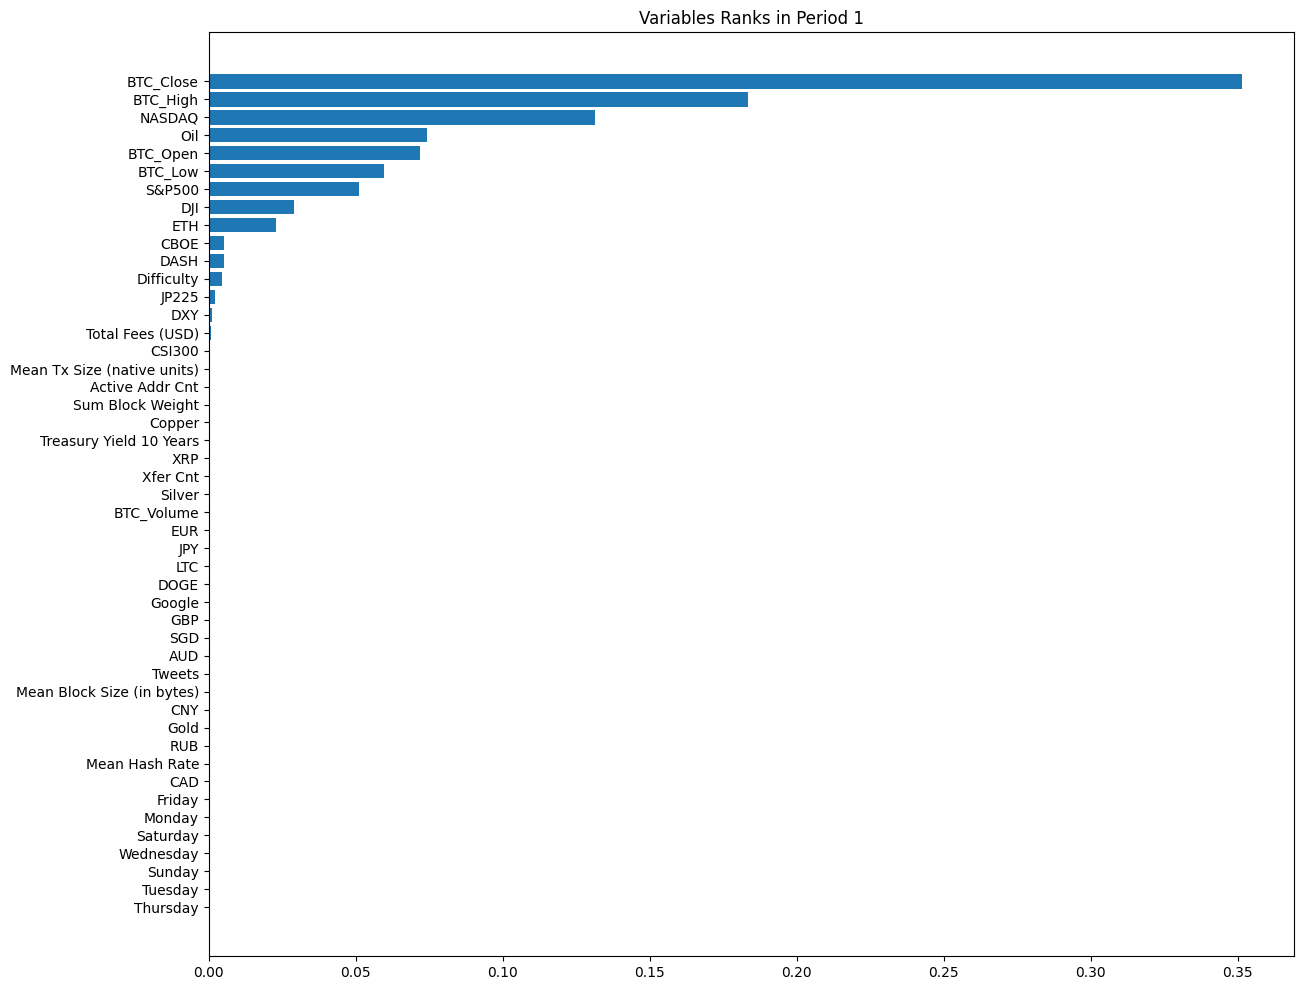

In [7]:
# Importance of variables
features = X_train.columns
importances = simpleTree.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(14,12))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.title("Variables Ranks in Period 1")
plt.show()

# Test

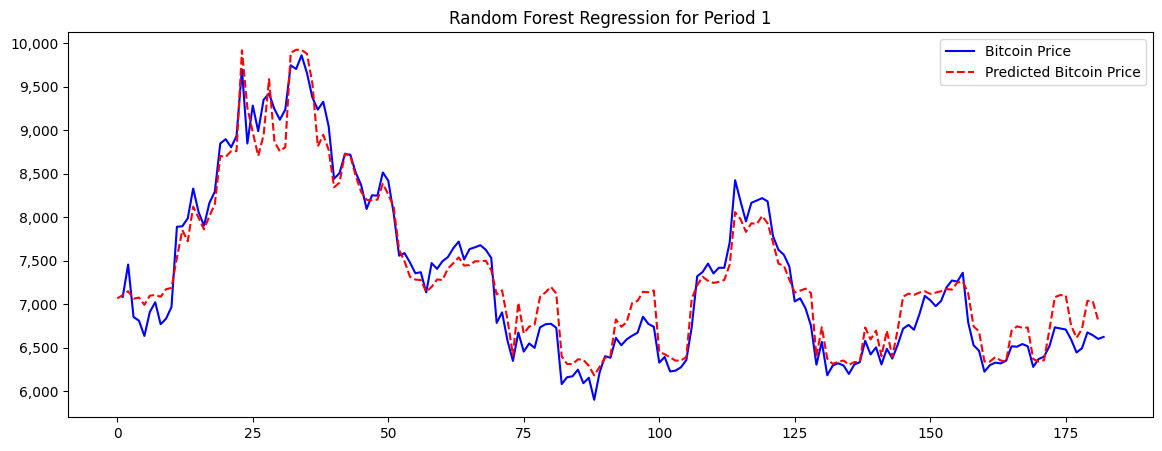

In [8]:
#予測値と観測値の比較
Y_pred  = simpleTree.predict(X_test)

#予測結果の表示
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(Y_test, color = 'blue', label="Bitcoin Price")
ax.plot(Y_pred, color = 'red', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # 3桁ごとカンマを書く
plt.title("Random Forest Regression for Period 1")
plt.legend()
plt.show()

In [9]:
#予測誤差の計算
#RMSE
from sklearn.metrics import mean_squared_error
print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print()

#MAPE
MAPE = np.average(np.abs((Y_test.values - Y_pred) / Y_test.values))
print("MAPE:", MAPE)
print()

#DA
Y_test_DA = np.array(Y_test)
Y_pred_0 = Y_pred[1:] - Y_test_DA[:-1]
Y_test_0 = Y_test[1:] - Y_test_DA[:-1]
DA = (Y_pred_0<0) == (Y_test_0<0)
print("DA accuracy:", f"{round(np.mean(DA)*100, 2)}%")

RMSE: 326.65154802801345

MAPE: 0.033912606217446704

DA accuracy: 51.93%
